In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import skelm

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sn

In [ ]:
i = 0
a = 50
b = 50

for root,_,files in os.walk("/home/akusok/HDD2TB/MCYTDB/"):
    if not 'overlap90p' in root:
        continue
    for f in files:
        i += 1
        if i < a:
            break
            
        fname = os.path.join(root, f)
        %time fdata = pd.read_parquet(fname)
        print(fname, fdata.shape)
        print()
        break
    if i > b:
        raise IOError

In [2]:
x = pd.read_parquet("/Users/akusok/wrkdir/research-signatures-data/MCYTDB/0013/overlap90p/cf-0016_0013f10_features.parquet.gz")

In [4]:
x.wsize.value_counts()

64     5016
128    1083
256     120
Name: wsize, dtype: int64

# 

## Make a dataset

In [2]:
data_kind = 'overlap90p'

In [ ]:
data = []
fid = 0

for root,_,files in os.walk("/Users/akusok/wrkdir/research-signatures-data/MCYTDB"):
    if not data_kind in root:
        continue
    uid = int(root.split("/")[-2])
    print(uid, end=', ')
    
    for f in files:
        fname = os.path.join(root, f)
        sig_true = int(f.startswith('c-'))
        fid += 1
        
        fdata = pd.read_parquet(fname)
        fdata['fname'] = fname
        fdata['uid'] = uid
        fdata['fid'] = fid
        fdata['sig_true'] = sig_true

        data.append(fdata)

X = pd.concat(data)
X.head()

112, 115, 114, 113, 66, 92, 50, 68, 57, 3, 32, 35, 58, 93, 67, 60, 33, 5, 2, 20, 18, 27, 29, 89, 45, 87, 73, 74, 80, 17, 10, 19, 26, 21, 81, 75, 72, 44, 109, 100, 107, 108, 116, 111, 118, 119, 117, 36, 31, 96, 62, 54, 98, 37, 8, 99, 52, 55, 63, 

In [ ]:
X.to_pickle("/Users/akusok/wrkdir/research-signatures-data/MCYTD_overlap90p.pkl")
del X

In [ ]:
3

# 

## Run ELM

In [6]:
X = pd.read_pickle("/home/akusok/HDD2TB/MCYTD_10p_n100.pkl").sample(n=20000)

In [7]:
Z = pd.concat((
    pd.get_dummies(X.uid, prefix='user'),
    X.drop(['wsize', 'overlap', 'xmin', 'ymin', 'xmax', 'ymax', 'uid'], axis=1)
), axis=1)

In [8]:
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] - Z.loc[:, '0':'1023'].mean()

In [9]:
# clip low standard deviation to avoid excessively large numbers
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] / Z.loc[:, '0':'1023'].std().clip(lower=0.5)

In [10]:
# limit the value range
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'].clip(lower=-5.0, upper=5.0)

In [11]:
Z = Z.reset_index(drop=True)

### get data

In [12]:
y = np.array(Z.sig_true)
x = np.array(Z.drop(['sig_true', 'fid'], axis=1))
groups = Z.fid

### experiments

In [13]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [14]:
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV

In [15]:
model = skelm.ELMClassifier(n_neurons=100, batch_size=2000)

In [ ]:
model.fit(x, y)

In [ ]:
model.score(x, y)

In [ ]:
%%time 
cross_val_score(model, x, y, groups=groups, cv=GroupKFold(n_splits=4)).mean()

### cross-validation

In [ ]:
grid = {
    'alpha': np.logspace(-5, 3, num=9, base=10),
    'ufunc': ['tanh', 'sigm', 'relu', 'lin'],
    'density': [0.01, 0.03, 0.1, 0.3, 1],
    'pairwise_metric': [None, 'cosine']
}

In [ ]:
os.environ['OMP_NUM_THREADS'] = '1'

In [ ]:
gcv = GridSearchCV(
    model,
    param_grid=grid,
    n_jobs=7,
    pre_dispatch=20,
    cv=GroupKFold(n_splits=3),
    verbose=1
)

In [ ]:
gcv.fit(x, y, groups=groups)

In [ ]:
results = pd.DataFrame(gcv.cv_results_)
results.head()

In [ ]:
results.groupby('param_alpha')['mean_test_score'].mean().plot(logx=True)

In [ ]:
results.groupby('param_density')['mean_test_score'].mean().plot(logx=True)

In [ ]:
results.fillna(-1).groupby('param_pairwise_metric')['mean_test_score'].mean()

In [ ]:
results.groupby('param_ufunc')['mean_test_score'].mean()

### second round mss

In [ ]:
grid2 = {
    'alpha': np.logspace(-3, 0, num=9, base=10),
    'ufunc': ['sigm', 'lin'],
    'density': np.logspace(-2, 0, num=7, base=10),
    'pairwise_metric': [None]
}

In [ ]:
os.environ['OMP_NUM_THREADS'] = '1'

In [ ]:
gcv2 = GridSearchCV(
    model,
    param_grid=grid2,
    n_jobs=12,
    pre_dispatch=30,
    cv=GroupKFold(n_splits=10),
    verbose=1
)

gcv2.fit(x, y, groups=groups)

In [ ]:
results2 = pd.DataFrame(gcv2.cv_results_)
results2.head()

In [ ]:
p = pd.pivot(results2[results2.param_ufunc == 'lin'], 
             values='mean_test_score', 
             columns='param_alpha', 
             index='param_density')
sn.heatmap(p)

In [ ]:
p = pd.pivot(results2[results2.param_ufunc == 'sigm'], 
             values='mean_test_score', 
             columns='param_alpha', 
             index='param_density')
sn.heatmap(p)

### evaluate neurons

In [16]:
grid3 = {
    'n_neurons': np.logspace(1.2, 14, base=2, num=19).astype(int),
    'alpha': np.logspace(-5, 2, num=9, base=10),
    'ufunc': ['sigm'],
    'density': [0.02],
    'pairwise_metric': [None]
}

In [17]:
gcv3 = GridSearchCV(
    model,
    param_grid=grid3,
    n_jobs=2,
    pre_dispatch=6,
    cv=GroupKFold(n_splits=3),
    verbose=1
)

gcv3.fit(x, y, groups=groups)

Fitting 3 folds for each of 171 candidates, totalling 513 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/home/akusok/miniconda3/envs/jupyter/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done 194 tasks      | elapsed: 12.4min
[Parallel(n_jobs=2)]: Done 444 tasks      | elapsed: 30.6min
[Parallel(n_jobs=2)]: Done 513 out of 513 | elapsed: 41.0min finished
/home/akusok/miniconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (1099 < 10008).The dimensionality of the problem will not be reduced.
  warnings.warn(


GridSearchCV(cv=GroupKFold(n_splits=3), error_score=nan,
             estimator=ELMClassifier(alpha=1e-07, batch_size=2000, classes=None,
                                     density=None,
                                     include_original_features=False,
                                     n_neurons=100, pairwise_metric=None,
                                     random_state=None, ufunc='tanh'),
             iid='deprecated', n_jobs=2,
             param_grid={'alpha': array([1.00000000e-05, 7.49894209e-05, 5.62341325e-04, 4.21696503e-03,
       3.16227766e-02, 2.37137371e-01, 1.77827941e+00, 1.33352143e+01,
       1.00000000e+02]),
                         'density': [0.02],
                         'n_neurons': array([    2,     3,     6,    10,    16,    27,    44,    72,   118,
         194,   317,   519,   851,  1393,  2281,  3734,  6113, 10008,
       16384]),
                         'pairwise_metric': [None], 'ufunc': ['sigm']},
             pre_dispatch=6, refit=True, ret

In [18]:
results3 = pd.DataFrame(gcv3.cv_results_)
results3.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_density,param_n_neurons,param_pairwise_metric,param_ufunc,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.154258,0.001280,0.033455,0.001502,1e-05,0.02,2,None,sigm,"{'alpha': 1e-05, 'density': 0.02, 'n_neurons':...",0.525124,0.506225,0.495500,0.508949,0.012247,165
1,0.149970,0.001496,0.030985,0.000436,1e-05,0.02,3,None,sigm,"{'alpha': 1e-05, 'density': 0.02, 'n_neurons':...",0.524374,0.533673,0.520102,0.526050,0.005666,153
2,0.150077,0.000630,0.031537,0.000254,1e-05,0.02,6,None,sigm,"{'alpha': 1e-05, 'density': 0.02, 'n_neurons':...",0.521974,0.523924,0.494149,0.513349,0.013600,163
3,0.153153,0.001167,0.031868,0.000225,1e-05,0.02,10,None,sigm,"{'alpha': 1e-05, 'density': 0.02, 'n_neurons':...",0.539823,0.536523,0.531053,0.535800,0.003617,141
4,0.158836,0.004089,0.036030,0.004374,1e-05,0.02,16,None,sigm,"{'alpha': 1e-05, 'density': 0.02, 'n_neurons':...",0.551372,0.561122,0.552955,0.555150,0.004272,126


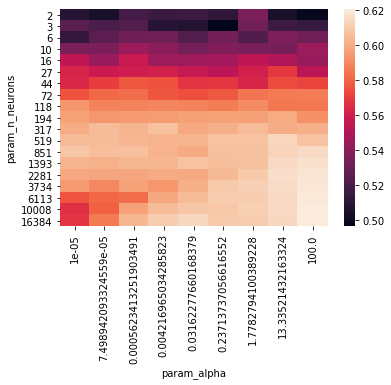

In [21]:
p = pd.pivot(results3, 
             values='mean_test_score', 
             columns='param_alpha', 
             index='param_n_neurons')
sn.heatmap(p)

## Final experiments

In [22]:
X = pd.read_pickle("/home/akusok/HDD2TB/MCYTD_10p_n100.pkl")

In [23]:
Z = pd.concat((
    pd.get_dummies(X.uid, prefix='user'),
    X.drop(['wsize', 'overlap', 'xmin', 'ymin', 'xmax', 'ymax', 'uid'], axis=1)
), axis=1)

In [24]:
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] - Z.loc[:, '0':'1023'].mean()

In [25]:
# clip low standard deviation to avoid excessively large numbers
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'] / Z.loc[:, '0':'1023'].std().clip(lower=0.5)

In [26]:
# limit the value range
Z.loc[:, '0':'1023'] = Z.loc[:, '0':'1023'].clip(lower=-5.0, upper=5.0)

In [27]:
Z = Z.reset_index(drop=True)

In [28]:
y = np.array(Z.sig_true)
x = np.array(Z.drop(['sig_true', 'fid'], axis=1))
groups = Z.fid

In [29]:
from sklearn.model_selection import cross_val_predict

In [30]:
model = skelm.ELMClassifier(alpha=10, n_neurons=1000, ufunc='sigm', density=0.02)

In [33]:
cvp = cross_val_predict(model, x, y, groups=groups, cv=GroupKFold(n_splits=10), n_jobs=3, pre_dispatch=3)

In [35]:
np.save("/home/akusok/HDD2TB/MCYTD_10p_n100-predict.npy", cvp)